In [1]:
%pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 25.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 19.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 4.8 MB/s eta 0:00:000:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.1
    Uninstalling numpy-2.1.1:
      Successfully uninstalled numpy-2.1.1
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import osmnx as ox
import networkx as nx

# Example: Download a map of a city
city_name = "San Francisco, California, USA"
graph = ox.graph_from_place(city_name, network_type="drive")


In [3]:
# Ensure edge lengths are present
graph = ox.distance.add_edge_lengths(graph)

# Accessing length of a specific edge
for u, v, k, data in graph.edges(keys=True, data=True):
    print(f"Edge from {u} to {v}: Length = {data['length']} meters")

Edge from 32927563 to 4377020523: Length = 3562.28 meters
Edge from 32927591 to 315706881: Length = 331.865 meters
Edge from 32927591 to 6469349533: Length = 791.633 meters
Edge from 32927645 to 65331336: Length = 1187.731 meters
Edge from 32927645 to 766946830: Length = 1035.748 meters
Edge from 33241803 to 2071244784: Length = 20.076 meters
Edge from 33241803 to 9209919063: Length = 12.521 meters
Edge from 33241803 to 8865870141: Length = 30.791 meters
Edge from 33242031 to 65292114: Length = 75.108 meters
Edge from 54891208 to 54891397: Length = 101.121 meters
Edge from 54891208 to 317126597: Length = 46.646 meters
Edge from 54891208 to 293818036: Length = 141.32 meters
Edge from 54891395 to 54891397: Length = 146.443 meters
Edge from 54891395 to 1998017252: Length = 146.57 meters
Edge from 54891395 to 984774300: Length = 101.335 meters
Edge from 54891397 to 54891395: Length = 146.443 meters
Edge from 54891397 to 300455591: Length = 212.056 meters
Edge from 54891397 to 54891208: Len

In [4]:
# Define default speed limits based on highway types
default_speeds = {
    'motorway': 100,
    'primary': 70,
    'secondary': 50,
    'residential': 30
}

# Add speed to edges
for u, v, k, data in graph.edges(keys=True, data=True):
    road_type = data.get('highway', None)
    # Check if road_type is a list and handle it
    if isinstance(road_type, list):
        # You can choose a strategy to handle multiple road types:
        # 1. Use the first road type in the list:
        road_type = road_type[0]  
        # 2. Prioritize certain road types:
        # for rt in road_type:
        #     if rt in default_speeds:
        #         road_type = rt
        #         break
    data['speed'] = default_speeds.get(road_type, 50)  # Default to 50 km/h

In [5]:
import random

for u, v, k, data in graph.edges(keys=True, data=True):
    road_type = data.get('highway', None)
    if road_type == 'motorway':
        data['traffic_density'] = random.uniform(0.5, 1.0)  # High density
    else:
        data['traffic_density'] = random.uniform(0.1, 0.5)  # Low density


In [6]:
for u, v, k, data in graph.edges(keys=True, data=True):
    length = data['length']  # meters
    speed_kph = data.get('speed', 50)  # km/h
    speed_mps = speed_kph * 1000 / 3600  # Convert km/h to m/s
    data['travel_time'] = length / speed_mps  # Seconds


In [7]:
bus_stops = ox.geometries_from_place("San Francisco, California, USA", tags={"highway": "bus_stop"})


/tmp/ipykernel_3770/823736507.py:1: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  bus_stops = ox.geometries_from_place("San Francisco, California, USA", tags={"highway": "bus_stop"})


In [8]:
bus_stops = bus_stops[bus_stops.geometry.type == 'Point']


In [9]:
# Extract coordinates (latitude and longitude) from geometry

bus_stops['x'] = bus_stops.geometry.x  # Longitude
bus_stops['y'] = bus_stops.geometry.y  # Latitude

In [10]:
# Map each bus stop to the nearest node in the graph
bus_stops['nearest_node'] = bus_stops.apply(
    lambda row: ox.distance.nearest_nodes(graph, X=row['x'], Y=row['y']), axis=1
)

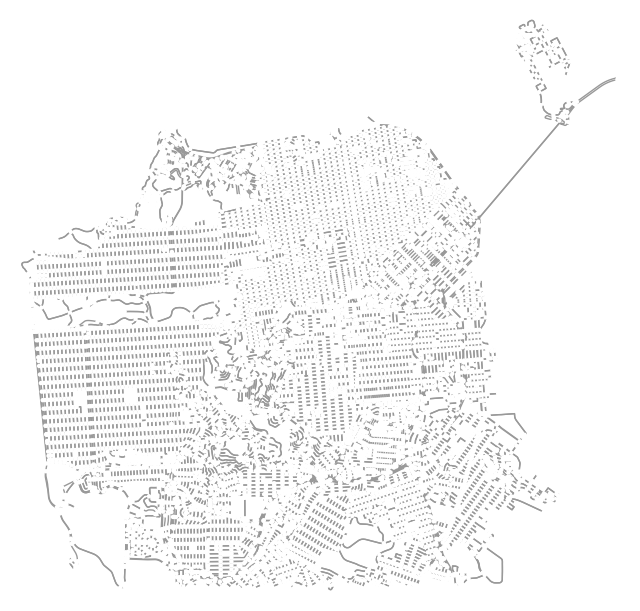

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [11]:
ox.plot_graph(graph, node_size=10, edge_linewidth=1, bgcolor='white')


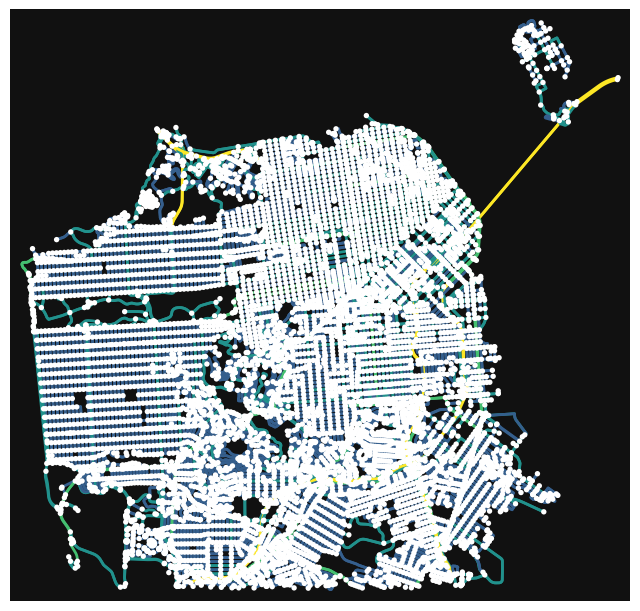

In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Generate edge colors based on the 'speed' attribute
edge_attribute = 'speed'  # Attribute to visualize
edge_colors = []

# Normalize the attribute for colormap
norm = mcolors.Normalize(vmin=0, vmax=100)  # Adjust vmax based on your data range
cmap = cm.viridis  # Choose a colormap

for u, v, k, data in graph.edges(keys=True, data=True):
    value = data.get(edge_attribute, 0)  # Default to 0 if attribute is missing
    edge_colors.append(cmap(norm(value)))

# Plot the graph
fig, ax = ox.plot_graph(graph, edge_color=edge_colors, edge_linewidth=2)
plt.show()